# Python Practice Lecture 17 MATH 342W Queens College 
# - Logistic Regression
## Author: Amir ElTabakh
## Date: April 7, 2022

## Agenda:
* Logistic Regression for Binary Response
* Probit and Cloglog probability estimation

## Logistic Regression for Binary Response

Let's clean up and load the cancer dataset, remove missing data, remove the ID column and add more appropriate feature names:

In [1]:
# importing dependencies
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import random

# Data viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("colorblind")) # setting color palette
sns.set(rc={"figure.figsize":(10, 6)}) #width=10, #height=6

In [2]:
# importing dataset
import statsmodels.api as sm
biopsy = sm.datasets.get_rdataset("biopsy","MASS")

biopsy.keys()

dict_keys(['data', '__doc__', 'package', 'title', 'from_cache'])

In [3]:
print(biopsy.__doc__)

.. container::

   ====== ===============
   biopsy R Documentation
   ====== ===============

   .. rubric:: Biopsy Data on Breast Cancer Patients
      :name: biopsy-data-on-breast-cancer-patients

   .. rubric:: Description
      :name: description

   This breast cancer database was obtained from the University of
   Wisconsin Hospitals, Madison from Dr. William H. Wolberg. He assessed
   biopsies of breast tumours for 699 patients up to 15 July 1992; each
   of nine attributes has been scored on a scale of 1 to 10, and the
   outcome is also known. There are 699 rows and 11 columns.

   .. rubric:: Usage
      :name: usage

   ::

      biopsy

   .. rubric:: Format
      :name: format

   This data frame contains the following columns:

   ``ID``
      sample code number (not unique).

   ``V1``
      clump thickness.

   ``V2``
      uniformity of cell size.

   ``V3``
      uniformity of cell shape.

   ``V4``
      marginal adhesion.

   ``V5``
      single epithelial cell siz

The documentation states:
```
``V6``
      bare nuclei (16 values are missing).
```
We'll have to deal with this missing data.

In [4]:
# snapshot
biopsy_df = biopsy.data.iloc[:, 1:] # remove ID column
biopsy_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,class
0,5,1,1,1,2,1.0,3,1,1,benign
1,5,4,4,5,7,10.0,3,2,1,benign
2,3,1,1,1,2,2.0,3,1,1,benign
3,6,8,8,1,3,4.0,3,7,1,benign
4,4,1,1,3,2,1.0,3,1,1,benign
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2.0,1,1,1,benign
695,2,1,1,1,2,1.0,1,1,1,benign
696,5,10,10,3,7,3.0,8,10,2,malignant
697,4,8,6,4,3,4.0,10,6,1,malignant


$trace(\mathcal{H}) = trace(V^{-1} \cdot D \cdot V) = trace(V^{-1} \cdot V \cdot D) = trace(D) = \Sigma\ \lambda_i$

Let's rename the columns.

In [5]:
biopsy_df.columns = ["clump_thickness",
                "cell_size_uniformity",
                "cell_shape_uniformity",
                "marginal_adhesion",
                "epithelial_cell_size",
                "bare_nuclei",
                "bland_chromatin",
                "normal_nucleoli",
                "mitoses",
                "class"
                    ]

biopsy_df

,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,5,1,1,1,2,1.0,3,1,1,benign
1,5,4,4,5,7,10.0,3,2,1,benign
2,3,1,1,1,2,2.0,3,1,1,benign
3,6,8,8,1,3,4.0,3,7,1,benign
4,4,1,1,3,2,1.0,3,1,1,benign
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2.0,1,1,1,benign
695,2,1,1,1,2,1.0,1,1,1,benign
696,5,10,10,3,7,3.0,8,10,2,malignant
697,4,8,6,4,3,4.0,10,6,1,malignant


The data may contain some rows with missing values. To eliminate such rows, use the following command.

In [6]:
# removing rows with missing values
biopsy_df = biopsy_df.dropna()
print(len(biopsy_df))

683


We dropped a number of rows, lets reset the index to avoid any bugs.

In [7]:
# reset index
biopsy_df = biopsy_df.reset_index(drop=True)

We can either estimate probability of the biopsy tissue being benign (this would mean y = 1 is the benign category level) or estimate the probability of the biopsy tissue being malignant (this would mean y = 1 is the malignant category level).

Let's go with the latter. To make the encoding explicitly 0/1, we can cast the factor to numeric or we can rely on R's default factor representation i.e. that the first level is 0 and the second level is 1. Here, we can use this default without reordering since the levels above show that benign is first and thus  = 0 and malignant is second and thus = 1 (via coincidence of alphabetical order).

In [8]:
biopsy_df["class"] = [0 if biopsy_df["class"][i] == 'benign' else 1 for i in range(len(biopsy_df))]
biopsy_df

,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,5,1,1,1,2,1.0,3,1,1,0
1,5,4,4,5,7,10.0,3,2,1,0
2,3,1,1,1,2,2.0,3,1,1,0
3,6,8,8,1,3,4.0,3,7,1,0
4,4,1,1,3,2,1.0,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
678,3,1,1,1,3,2.0,1,1,1,0
679,2,1,1,1,2,1.0,1,1,1,0
680,5,10,10,3,7,3.0,8,10,2,1
681,4,8,6,4,3,4.0,10,6,1,1


Now let's split into training and testing subsets for experiments!

In [9]:
# check out the documentation
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets.
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to 

In [10]:
# defining X and y
X = biopsy_df.iloc[:, :-1]
y = biopsy_df.iloc[:, -1]

# adding 1 vector to X
X.insert(0, "one_vec", 1)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 1984)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(512, 10)
(171, 10)
(512,)
(171,)


Scikit learn does not have the link functions relevant to this class (they have others, feel free to take a [look](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression).

We'll be using our handy dandy `statsmodel` library.

In [11]:
# Documentation
#help(sm.Logit)

In [12]:
# importing dependencies
import statsmodels.api as sm

logistic_mod = sm.Logit(y_train, X_train).fit()

logistic_mod.summary()

Optimization terminated successfully.
         Current function value: 0.077964
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  class   No. Observations:                  512
Model:                          Logit   Df Residuals:                      502
Method:                           MLE   Df Model:                            9
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.8822
Time:                        13:53:21   Log-Likelihood:                -39.918
converged:                       True   LL-Null:                       -338.72
Covariance Type:            nonrobust   LLR p-value:                6.838e-123
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
one_vec                  -9.9954      1.366     -7.317      0.000     -12.673      -7.318
clump_thickness           0.5827      0.172      3.378      0.001       0.245       0.921
cell_size_uniformity     -0.1183      0.240     -0.493      0.622      -0.589       0.352
cell_shape_uniformity     0.3575      0.259      1.380      0.168      -0.150       0.865
marginal_adhesion         0.4915      0.167      2.943      0.003       0.164       0.819
epithelial_cell_size      0.1303      0.191      0.684      0.494      -0.243       0.504
bare_nuclei               0.3978      0.115      3.464      0.001       0.173       0.623
bland_chromatin           0.3773      0.181      2.086      0.037       0.023       0.732
normal_nucleoli           0.2011      0.136      1.481      0.139      -0.065       0.467
mitoses                   0.4661      0.426      1.095      0.273      -0.368       1.300
=========================================================================================

Possibly complete quasi-separation: A fraction 0.10 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

That was fast! There was actually a lot of optimization in that line.

Interpretation? If clump thickness increases by one unit the log odds of malignancy increases by 0.5827...

All but one of the coefficients are positive which means if any those covariates increase...

And let's take a look at the fitted values:

In [13]:
# getting predictions
yhat = list(map(round, logistic_mod.predict(X_test)))
yhat[0:10]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 0]

The Logit fit function actually provides a lit of probabilities. I mapped the round function so I could get values in the support of my response. Let's check out the probabilities the model evaluated.

In [14]:
logistic_mod.predict(X_test)[0:20]

539    0.002977
544    0.013772
487    0.012587
403    0.109261
123    0.001356
54     0.976667
205    0.999795
356    0.009924
386    0.999872
375    0.028139
61     0.480505
597    1.000000
339    0.999864
671    0.006468
672    0.005319
666    0.024296
455    0.003808
305    0.002919
456    0.043815
331    0.000930
dtype: float64

Let's take a look at all the in-sample probability estimates:

<AxesSubplot:ylabel='Count'>

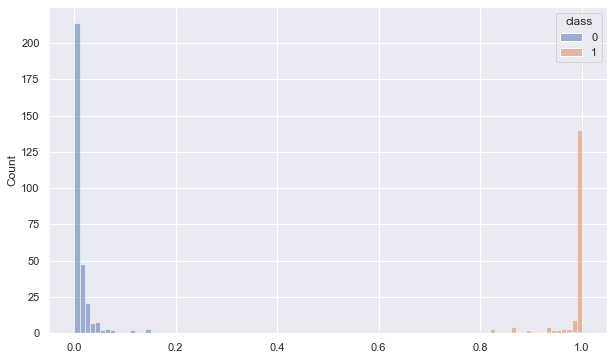

In [15]:
# probability hats via the training set
p_hats_train = list(logistic_mod.predict(X_train))

# lets plot how the model did
sns.histplot(x = p_hats_train, hue = y_train, bins = 100) # 0 begign, 1 malignant

This is how the response looks in the dataset.

<AxesSubplot:xlabel='class', ylabel='Count'>

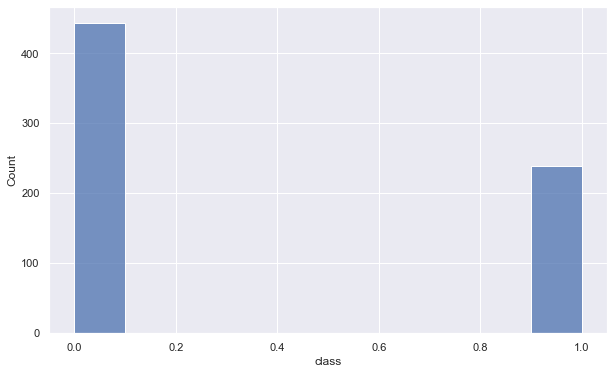

In [16]:
# lets plot how the model did
sns.histplot(x = biopsy_df['class'], bins = 10) # 0 begign, 1 malignant

It's very sure of itself! 

Let's see $y$ by $\hat{p}$ another way:

E:\Users\amira\anaconda\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 43.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
E:\Users\amira\anaconda\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 35.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='class'>

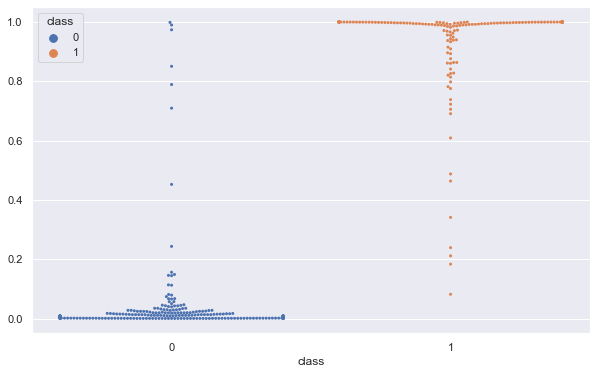

In [17]:
# 0 begign, 1 malignant
#sns.violinplot(x = y_train, y = p_hats_train, inner=None)
sns.swarmplot(x = y_train, y = p_hats_train, hue=y_train, size=3)

Made only a few mistakes here and there in the training set! How about the test set?

<AxesSubplot:ylabel='Count'>

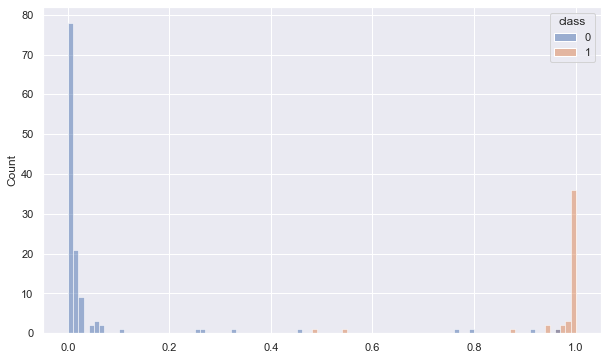

In [18]:
# probability hats via the testing set
p_hats_test = list(logistic_mod.predict(X_test))

# lets plot how the model did
sns.histplot(x = p_hats_test, hue = y_test, bins = 100) # 0 begign, 1 malignant

<AxesSubplot:xlabel='class'>

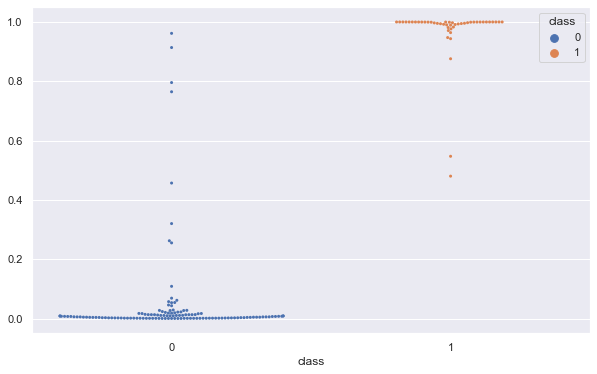

In [19]:
# using a swarm plot
sns.swarmplot(x = y_test, y = p_hats_test, hue=y_test, size=3)

Looks pretty good! We now will talk about error metrics for probabilistic estimation models. That will give us a way to validate this model and provide an estimate of future performance. 

#### Brier Score

A Brier Score is a metric to measure the accuracy of probabilistic forecasts. It is typically used when the outcome of a forecast is binary, that is, either the outcome occurs or it doesn't. For example, suppose a weather forecast says there is a 90% chance of rain and it actually does rain. We can calculate the Brier Score for this forecast using the following formula:

$(f - o)^2$

Where,

* $f$ is the forecasted probability
* $o$ is the actual outcome (1 if the event occurs, 0 if it doesn't)

In this example, the Brier Score for our forecast would be $(0.9 – 1)^2 = -0.1^2 = 0.01$

A Brier Score for a set of forecasts is simply calculated as the average of the Brier Scores for the individual forecasts:

$\Sigma (f_t - o_t)^2 \times \frac{1}{n}$

A Brier Score can take on any value between 0 and 1, with 0 being the best score achievable and 1 being the worst score achievable. The lower the Brier Score, the more accurate the prediction(s).

What is the in-sample average Brier score?

In [20]:
np.mean((p_hats_train - y_train)**2)

0.019281564821271514

This is very good Brier score! Again, most of the probabilities were spot on. And the oos Brier score?

In [21]:
np.mean((p_hats_test - y_test)**2)

0.02322118286199541

Not as good but still very good!

What is the in-sample log score?

In [22]:
one_minus_p_hat_train = [1 - p_hats_train[i] for i in range(len(p_hats_train))]
np.mean(y_train * np.log(p_hats_train) + (1 - y_train) * np.log(one_minus_p_hat_train))

-0.07796428000764244

This isn't bad (if you get intuition in reading them). And oos?

In [23]:
one_minus_p_hat_test = [1 - p_hats_test[i] for i in range(len(p_hats_test))]
np.mean(y_test * np.log(p_hats_test) + (1 - y_test) * np.log(one_minus_p_hat_test))

-0.07898214502012264

Not as good but still very good!

If we wanted to be more careful, we can use K-fold CV to get a less variable oos metric. Maybe we'll do that in a lab?


## Probit and Cloglog probability estimation

These are different generalized linear models but fit using the same code. All we need to do is change the link argument. For a probit regression we just do:

In [24]:
from statsmodels.discrete.discrete_model import Probit

probit_mod = Probit(y_train, X_train).fit()

probit_mod.summary2()

Optimization terminated successfully.
         Current function value: 0.079211
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Probit
=====================================================================
Model:               Probit            Pseudo R-squared:  0.880      
Dependent Variable:  class             AIC:               101.1120   
Date:                2022-01-29 13:53  BIC:               143.4953   
No. Observations:    512               Log-Likelihood:    -40.556    
Df Model:            9                 LL-Null:           -338.72    
Df Residuals:        502               LLR p-value:       1.2851e-122
Converged:           1.0000            Scale:             1.0000     
No. Iterations:      9.0000                                          
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
one_vec               -4.9617   0.5613 -8.8389 0.0000 -6.0619 -3.8614
clump_thickness        0.2589   0.0810  3.1962 0.0014  0.1001  0.4176
cell_size_uniformity  -0.0321   0.1160 -0.2764 0.7822 -0.2594  0.1953
cell_shape_uniformity  0.2249   0.1275  1.7644 0.0777 -0.0249  0.4747
marginal_adhesion      0.2012   0.0785  2.5622 0.0104  0.0473  0.3551
epithelial_cell_size   0.0949   0.1047  0.9057 0.3651 -0.1104  0.3001
bare_nuclei            0.1918   0.0530  3.6174 0.0003  0.0879  0.2958
bland_chromatin        0.1725   0.0884  1.9520 0.0509 -0.0007  0.3458
normal_nucleoli        0.0823   0.0650  1.2670 0.2051 -0.0450  0.2097
mitoses                0.1833   0.1754  1.0452 0.2960 -0.1605  0.5272
=====================================================================

"""

As we saw before, almost all coefficients for the covariates are positive. What's the interpretation of $b$ for `bare_nuclei`?

Let's take a look at all the in-sample probability estimates:

<AxesSubplot:ylabel='Count'>

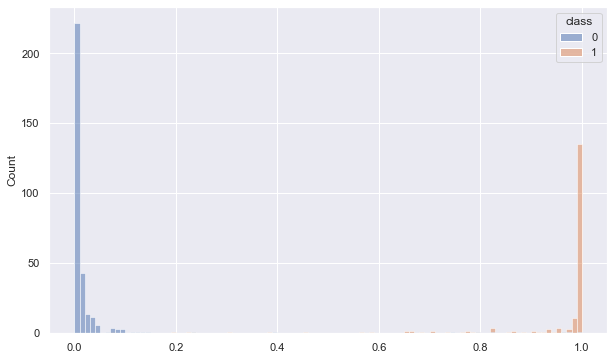

In [25]:
# probability hats via the training set
p_hats_train = list(probit_mod.predict(X_train))

# lets plot how the model did
sns.histplot(x = p_hats_train, hue = y_train, bins = 100) # 0 begign, 1 malignant

<AxesSubplot:ylabel='Count'>

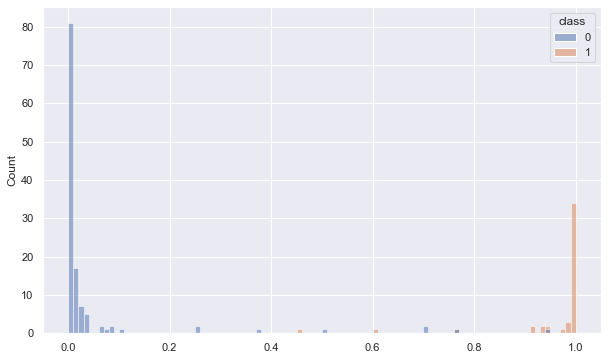

In [26]:
# probability hats via the training set
p_hats_test = list(probit_mod.predict(X_test))

# lets plot how the model did
sns.histplot(x = p_hats_test, hue = y_test, bins = 100) # 0 begign, 1 malignant

Also basically the same-looking. To get an apples-apples comparison with logistic regression let's calculate the brier and log scoring metrics:

In [27]:
# calculating performance metrics for training data

brier_probit_train = np.mean((p_hats_train - y_train)**2)

print(f"Brier Score Train: {brier_probit_train}")

one_minus_p_hat_train = [1 - p_hats_train[i] for i in range(len(p_hats_train))]
log_score_probit_train = np.mean(y_train * np.log(p_hats_train) + (1 - y_train) * np.log(one_minus_p_hat_train))

print(f"Log Score Train: {log_score_probit_train}")

Brier Score Train: 0.02082164675278907
Log Score Train: -0.07921097861123534


In [28]:
# calculating performance metrics for testing data

brier_probit_test = np.mean((p_hats_test - y_test)**2)

print(f"Brier Score Test: {brier_probit_test}")

one_minus_p_hat_test = [1 - p_hats_test[i] for i in range(len(p_hats_test))]
log_score_probit_test = np.mean(y_test * np.log(p_hats_test) + (1 - y_test) * np.log(one_minus_p_hat_test))

print(f"Log Score Test: {log_score_probit_test}")

Brier Score Test: 0.020805962946753173
Log Score Test: -0.06907317143466227


It appears the logistic regression is better oos.

In addition to logit and probit regression, any continuous distribution from SciPy.stats package can be used for the distr argument. Alternatively, one can define its own distribution simply creating a subclass from rv_continuous and implementing a few methods.

In [29]:
# we'll have to remove the intercept column for the OrderedModel function to work
del X_train['one_vec']
del X_test['one_vec']

In [30]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from statsmodels.miscmodels.ordinal_model import OrderedModel


# minimal definition of a custom scipy distribution.
class CLogLog(stats.rv_continuous):
    def _ppf(self, q):
        return np.log(-np.log(1 - q))

    def _cdf(self, x):
        return 1 - np.exp(-np.exp(x))


cloglog = CLogLog()

# definition of the model and fitting
mod_cloglog = OrderedModel(y_train,
                           X_train,
                           distr=cloglog).fit(method='bfgs', disp=False)
mod_cloglog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  class   Log-Likelihood:                -33.710
Model:                   OrderedModel   AIC:                             87.42
Method:            Maximum Likelihood   BIC:                             129.8
Date:                Sat, 29 Jan 2022                                         
Time:                        13:53:25                                         
No. Observations:                 512                                         
Df Residuals:                     502                                         
Df Model:                          10                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
clump_thickness           0.3517      0.124      2.838      0.005       0.109       0.595
cell_size_uniformity      0.0060      0.189      0.032      0.975      -0.364       0.376
cell_shape_uniformity     0.2000      0.180      1.110      0.267      -0.153       0.553
marginal_adhesion         0.2990      0.120      2.488      0.013       0.063       0.534
epithelial_cell_size      0.0306      0.132      0.232      0.816      -0.227       0.289
bare_nuclei               0.3158      0.084      3.773      0.000       0.152       0.480
bland_chromatin           0.2151      0.131      1.644      0.100      -0.041       0.472
normal_nucleoli           0.1251      0.097      1.290      0.197      -0.065       0.315
mitoses                   0.3561      0.219      1.627      0.104      -0.073       0.785
0/1                       5.6784      0.968      5.869      0.000       3.782       7.575
=========================================================================================
"""

Same signs on coefficients. Interpretation? Difficult... 

Let's take a look at all the in-sample and out of sample probability estimates:

<AxesSubplot:xlabel='0', ylabel='Count'>

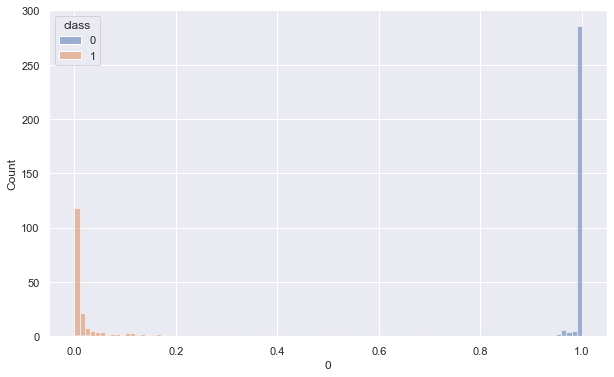

In [31]:
# probability hats via the training set
p_hats_train = mod_cloglog.predict(X_train, which = "prob").iloc[:, 0]

# lets plot how the model did
sns.histplot(x = p_hats_train, hue = y_train, bins = 100) # 0 begign, 1 malignant

<AxesSubplot:xlabel='0', ylabel='Count'>

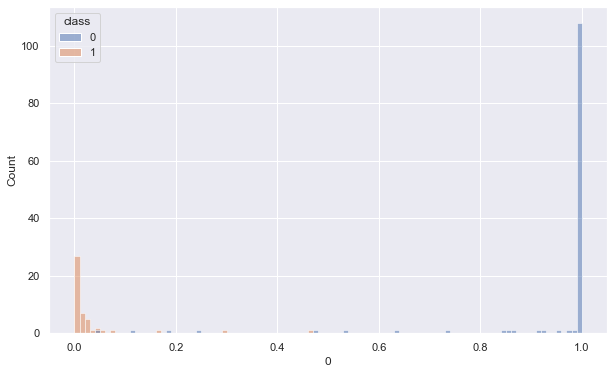

In [32]:
# probability hats via the testing set
p_hats_test = mod_cloglog.predict(X_test, which = "prob").iloc[:, 0]

# lets plot how the model did
sns.histplot(x = p_hats_test, hue = y_test, bins = 100) # 0 begign, 1 malignant

Let's see how it does compared to the logistic and probit models.

In [33]:
# In sample Brier Score
print(np.mean((p_hats_train - y_train)**2))

0.9492046881753748


In [34]:
# Out of sample Brier Score
print(np.mean((p_hats_test - y_test)**2))

0.9393397608267596
